# Imports

In [48]:
import numpy as np
from pathlib import Path
import sys
import matplotlib.pyplot as plt
sys.path.append(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\10_code\UTvsXCT-preprocessing')
from preprocess_tools import io, signal

# Load data

In [49]:
folder = Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Probetas JI\probetas\2025 methodology')

#get all the folders
subfolders = [f for f in folder.iterdir() if f.is_dir()]

#for each folder get all the tif files that doesnt have the _amplitude suffix neither the _volfrac and it has to be .tif
tif_files = []
for subfolder in subfolders:
    tif_files.extend(list(subfolder.glob('*.tif')))
tif_files = [f for f in tif_files if '_amplitude' not in f.stem and '_volfrac' not in f.stem and f.suffix == '.tif']

#get the filenames without the extension
tif_filenames = [f.stem for f in tif_files]

#load the files
volumes = []
for f in tif_files:
    vol = io.load_tif(f)
    vol = vol.swapaxes(0,2) #swap axes to have the correct orientation
    volumes.append(vol)

# align signals

In [50]:
for i,vol in enumerate(volumes):
    volumes[i] = signal.align_signals_optimized(vol)

Aligning signal batches: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


# Compute envelope

In [51]:
envelope_volumes = []
for vol in volumes:
    envelope_volumes.append(signal.envelope(vol))

# Mean signal

In [52]:
def sample_wise_mean(volume, lim=10):
    # volume shape must be (x,y,time)
    # Flatten all but the last axis (assume last axis is signal)
    reshaped = volume.reshape(-1, volume.shape[-1])
    # Find max value of each signal
    max_vals = reshaped.max(axis=1)
    # Select signals with max above lim
    valid_signals = reshaped[max_vals > lim]
    # Compute mean signal and count
    count = valid_signals.shape[0]
    if count == 0:
        return np.zeros(volume.shape[-1]), 0
    return valid_signals.mean(axis=0), count

In [53]:
mean_signals = []
counts = []

for vol in envelope_volumes:
    mean, count = sample_wise_mean(vol)
    mean_signals.append(mean)
    counts.append(count)

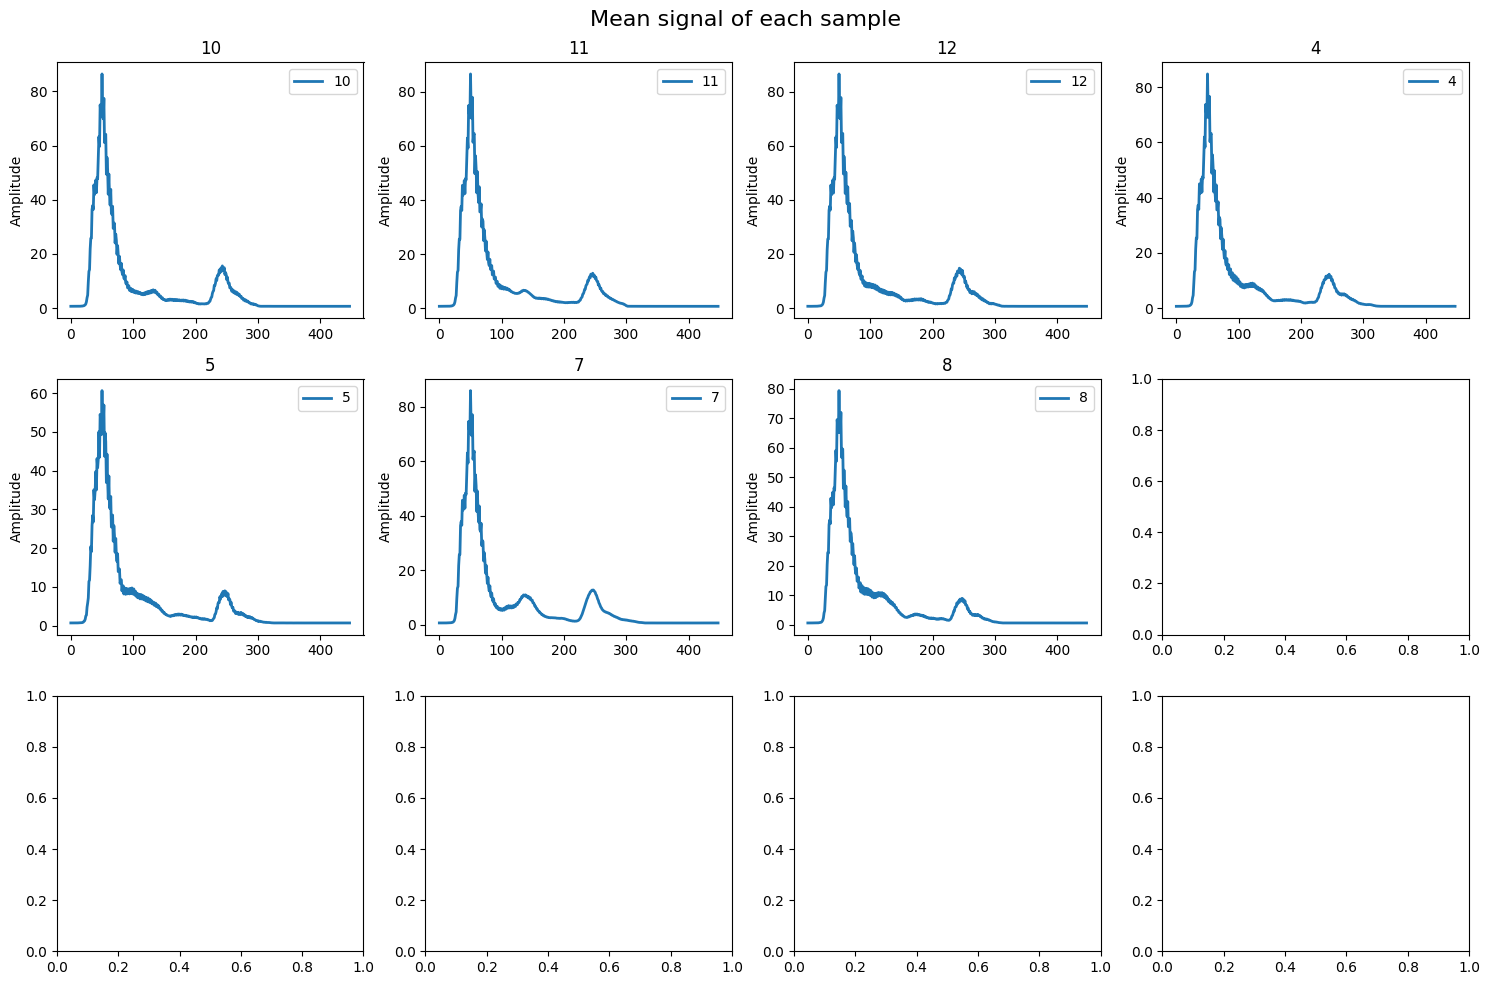

In [54]:
#create a figure that with enough subplots to plot all mean signals
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

for i in range(len(mean_signals)):
    mean_signal = mean_signals[i]
    name = tif_filenames[i]
    axs[i // 4, i % 4].plot(mean_signal, label=name, linewidth=2)
    axs[i // 4, i % 4].set_title(name)
    axs[i // 4, i % 4].set_ylabel('Amplitude')
    axs[i // 4, i % 4].legend()


plt.suptitle("Mean signal of each sample", fontsize=16)
plt.tight_layout()
plt.show()